In [2]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
from src.db import q

In [4]:
from src.cohort import load_aki_cohort

df_aki = load_aki_cohort()
df_aki.head()


,subject_id,hadm_id,icustay_id,intime,outtime,gender,dob,admittime,dischtime,deathtime,ethnicity,age,hospital_mortality
0,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,M,2025-04-11,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,WHITE,76.0,0
1,9,150750,220597,2149-11-09 13:07:02,2149-11-14 20:52:14,M,2108-01-26,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,UNKNOWN/NOT SPECIFIED,41.0,1
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,M,2047-04-04,2134-09-11 12:17:00,2134-09-24 16:15:00,NaT,WHITE,87.0,0
3,38,185910,248910,2166-08-10 00:29:36,2166-09-04 13:39:23,M,2090-08-31,2166-08-10 00:28:00,2166-09-04 11:30:00,NaT,WHITE,75.0,0
4,52,190797,261857,2191-01-10 02:12:55,2191-01-11 22:37:31,M,2152-11-26,2191-01-10 02:12:00,2191-01-19 16:10:00,NaT,WHITE,38.0,0


In [5]:
df_aki["age"].min(), df_aki["age"].max()


(np.float64(18.0), np.float64(89.0))

In [6]:
df_aki["hospital_mortality"].value_counts()




hospital_mortality
0    8190
1    2295
Name: count, dtype: int64

In [7]:
df_aki["hospital_mortality"].mean()

np.float64(0.21888412017167383)

In [8]:
df_aki.groupby(pd.cut(df_aki["age"], [18,40,60,75,90]))["hospital_mortality"].mean()


C:\Users\Simon\AppData\Local\Temp\ipykernel_18168\3482040816.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aki.groupby(pd.cut(df_aki["age"], [18,40,60,75,90]))["hospital_mortality"].mean()


age
(18, 40]    0.167155
(40, 60]    0.181631
(60, 75]    0.213840
(75, 90]    0.267083
Name: hospital_mortality, dtype: float64

In [9]:
df_aki["icu_los_days"] = (df_aki["outtime"] - df_aki["intime"]).dt.total_seconds() / (3600 * 24)
df_aki["icu_los_days"].describe()


count    10485.000000
mean         6.094141
std          8.469640
min          0.000139
25%          1.683449
50%          3.022685
75%          6.835428
max        153.927975
Name: icu_los_days, dtype: float64

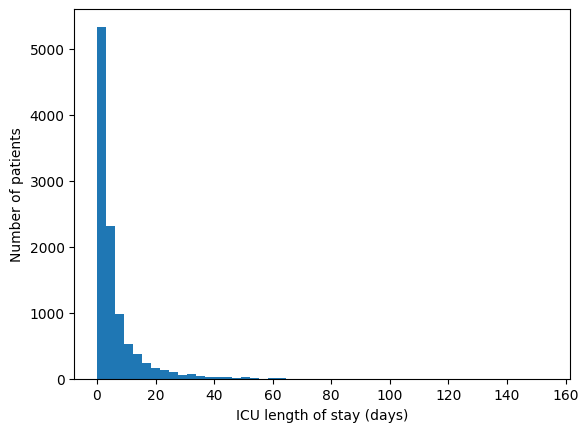

In [10]:
import matplotlib.pyplot as plt

plt.hist(df_aki["icu_los_days"], bins=50)
plt.xlabel("ICU length of stay (days)")
plt.ylabel("Number of patients")
plt.show()


In [11]:
df_rrt_proc = q("""
SELECT DISTINCT pe.icustay_id
FROM procedureevents_mv pe
JOIN d_items di ON pe.itemid = di.itemid
WHERE
    LOWER(di.label) LIKE '%hemodial%'
 OR LOWER(di.label) LIKE '%haemodial%'
 OR LOWER(di.label) LIKE '%crrt%'
 OR LOWER(di.label) LIKE '%dialysis%'
""")

df_rrt_icd = q("""
SELECT DISTINCT hadm_id
FROM procedures_icd
WHERE icd9_code IN ('3995','5498')
""")

df_aki["dialysis"] = (
    df_aki["icustay_id"].isin(df_rrt_proc["icustay_id"])
    | df_aki["hadm_id"].isin(df_rrt_icd["hadm_id"])
).astype(int)

df_aki["dialysis"].mean()


np.float64(0.13218884120171673)

In [12]:
df_aki.groupby("dialysis").agg(
    n=("dialysis", "count"),
    mortality=("hospital_mortality", "mean"),
    icu_los_median=("icu_los_days", "median")
)


,n,mortality,icu_los_median
dialysis,,,
0,9099,0.197494,2.837998
1,1386,0.359307,6.988345


In [13]:
from scipy.stats import chi2_contingency
import pandas as pd

table = pd.crosstab(df_aki["dialysis"], df_aki["hospital_mortality"])
chi2, p, _, _ = chi2_contingency(table)
p


np.float64(9.443070680055335e-42)

In [14]:
df_aki["dialysis"].value_counts()

dialysis
0    9099
1    1386
Name: count, dtype: int64